# Predict today's direction based on all other variables
This notebook follows the lab exercise for ISLR Classification Chapter

Lag1-5 are the % returns of the previous 5 days

Create a correlation matrix between the Variables (except Direction, which is qualititative) 

In [ ]:
library(ISLR)
attach(Smarket)

In [21]:
cor(Smarket[,-9])

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.00000000,0.029699649,0.030596422,0.033194581,0.035688718,0.029787995,0.53900647,0.030095229
Lag1,0.02969965,1.000000000,-0.026294328,-0.010803402,-0.002985911,-0.005674606,0.04090991,-0.026155045
Lag2,0.03059642,-0.026294328,1.000000000,-0.025896670,-0.010853533,-0.003557949,-0.04338321,-0.010250033
Lag3,0.03319458,-0.010803402,-0.025896670,1.000000000,-0.024051036,-0.018808338,-0.04182369,-0.002447647
Lag4,0.03568872,-0.002985911,-0.010853533,-0.024051036,1.000000000,-0.027083641,-0.04841425,-0.006899527
Lag5,0.02978799,-0.005674606,-0.003557949,-0.018808338,-0.027083641,1.000000000,-0.02200231,-0.034860083
Volume,0.53900647,0.040909908,-0.043383215,-0.041823686,-0.048414246,-0.022002315,1.00000000,0.014591823
Today,0.03009523,-0.026155045,-0.010250033,-0.002447647,-0.006899527,-0.034860083,0.01459182,1.000000000


### Analysis
* There's no correlation between today's returns and LagN variables (close to zero)
* The only meaningful relationship seems to be between Volume and Year 

# Logistic Regression

Logistic Regression is denoted by the `family=binomial` argument

In [2]:
glmfit=glm(Direction~Lag1+Lag2+Lag3+Lag4+Lag5+Volume,data=Smarket,family=binomial)
summary(glmfit)


Call:
glm(formula = Direction ~ Lag1 + Lag2 + Lag3 + Lag4 + Lag5 + 
    Volume, family = binomial, data = Smarket)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.446  -1.203   1.065   1.145   1.326  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)
(Intercept) -0.126000   0.240736  -0.523    0.601
Lag1        -0.073074   0.050167  -1.457    0.145
Lag2        -0.042301   0.050086  -0.845    0.398
Lag3         0.011085   0.049939   0.222    0.824
Lag4         0.009359   0.049974   0.187    0.851
Lag5         0.010313   0.049511   0.208    0.835
Volume       0.135441   0.158360   0.855    0.392

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1731.2  on 1249  degrees of freedom
Residual deviance: 1727.6  on 1243  degrees of freedom
AIC: 1741.6

Number of Fisher Scoring iterations: 3


### Analysis
* Smallest p-value is for Lag1. And the coef is negative, so if market moved up last day, then it will move down today
* But its p-value is still relatively high ($>0.05$), so no clear evidence of association betw Direction and Lag1
* The `contrasts(Direction)` function indicates that R has created a dummy variable with a 1 for `Up`

Use the `predict` function to predict (duh!) the probability that the market will go up/down

The `type="response"` option tells R to output probabilities for $P(Y=1|X)$, as opposed to other info like the Logit

As no data is supplied to the `predict` function, it will try to predict for the training data set itself

In [3]:
glmprobs=predict(glmfit,type="response")
glmprobs[1:10]  #As Up is denoted by 1, these probs are for the market going up
contrasts(Direction)

1         2         3         4         5         6         7         8 
0.5070841 0.4814679 0.4811388 0.5152224 0.5107812 0.5069565 0.4926509 0.5092292 
        9        10 
0.5176135 0.4888378

,Up
Down,0
Up,1


To predict whether the market will go up or down, lets convert the probabilities into class labels

First create a vector with 1250 <sub>(count of original dataset)</sub> "Down" values. 

We use a threshold of 0.5, so if the calculated prob > 0.5, then the market is assumed to move upwards

In [4]:
glmpred=rep("Down",1250)
glmpred[glmprobs>0.5]="Up"
head(glmpred)   #Look at some of the predictions

[1] "Up"   "Down" "Down" "Up"   "Up"   "Up"

Now create a **Confusion matrix** to determine how many obs were correctly classified

`glmpred` contains 1250 computed predictions, and `Direction` from the DF contains 1250 actual direction values

So this will tell how many observations match and how many don't

In [5]:
table(glmpred,Direction)
cat('Accurate Prediction Rate', (507+145)/1250)
mean(glmpred==Direction)

       Direction
glmpred Down  Up
   Down  145 141
   Up    457 507

Accurate Prediction Rate 0.5216

[1] 0.5216

### Analysis
* Accurate predictions only 52% of the time
* It doesn't look much better than random guessing
* However, we tested the model on the **training** set, which leads to more optimistic results
* This means the model may actually be performing worse
* So let's now create a training set, containing data for years before 2005. Then we'll test with data 2005 onwards. The `.2005` variables contain the 2005 which will be our **test** dataset

In [6]:
train=(Year<2005)
Smarket.2005=Smarket[!train,]
dim(Smarket.2005)
Direction.2005=Direction[!train]

[1] 252   9

Use the `subset=train` arg which will tell the `glm` function to take only data subset specified by the `train` variable above

In [7]:
glmfit=glm(Direction~Lag1+Lag2+Lag3+Lag4+Lag5+Volume,family=binomial,data=Smarket,subset=train)

glmprobs=predict(glmfit,Smarket.2005,type="response")

glmpred=rep("Down",252)
glmpred[glmprobs>0.5]="Up"

# Now compare predictions vs actual 2005 values
table(glmpred,Direction.2005)

mean(glmpred!=Direction.2005)  # Will give the total error rate

       Direction.2005
glmpred Down Up
   Down   77 97
   Up     34 44

[1] 0.5198413

### Analysis
Error Rate: 52% 

So essentially, this is worse than simple coin-tossing

Which makes sense, as it isn't plausible that the stock market can be reliably predicted by looking at previous days' prices

It also makes sense because the p-values were not very impressive

Let's try to remove some additional variables. It might help, as using superfluous predictors can cause deteriotation, as those predictors cause increase in variance without a corresponding decrease in bias.

Let's try with just Lag1 and Lag2

In [8]:
glmfit=glm(Direction~Lag1+Lag2,family=binomial,data=Smarket,subset=train)
glmprobs=predict(glmfit,Smarket.2005,type="response")

glmpred=rep("Down",252)
glmpred[glmprobs>0.5]="Up"

# Now compare predictions vs actual 2005 values
table(glmpred,Direction.2005)

cat('Total Error Rate:',100*mean(glmpred!=Direction.2005),'%\n')  # Will give the total error rate
cat('PPV:',106/(106+76)*100,'%\n')        # Will give the Positive Pred Val (PPV)
cat('Up Probability in test set: ',mean(Direction.2005=="Up")*100,'%')  # How many times in the test set did the market move upwards?

       Direction.2005
glmpred Down  Up
   Down   35  35
   Up     76 106

Total Error Rate: 44.04762 %
PPV: 58.24176 %
Up Probability in test set:  55.95238 %

Slightly better. We get the positives *correct* 58% of the time. This is the Positive Pred Value (PPV)

$$PPV = \frac{\sum True Positive}{\sum All Positives} = 58.24\% $$

$$True Positive = 106 $$ 
$$All Positives = 106+76 $$


But... in the test dataset, market moves up 56% of days. So if we just blindly "predicted" that that market would go Up each day, we would achieve the same "accuracy" 

Yet, let's try to see what predictions we get for a couple of combinations of Lag1 and Lag2

In [9]:
predict (glmfit ,newdata=data.frame(Lag1=c(1.2 ,1.5) ,Lag2=c(1.1 , -0.8) ),type ="response")

1         2 
0.4791462 0.4960939

Let's also see some diagnostic plots for Logistic Regression

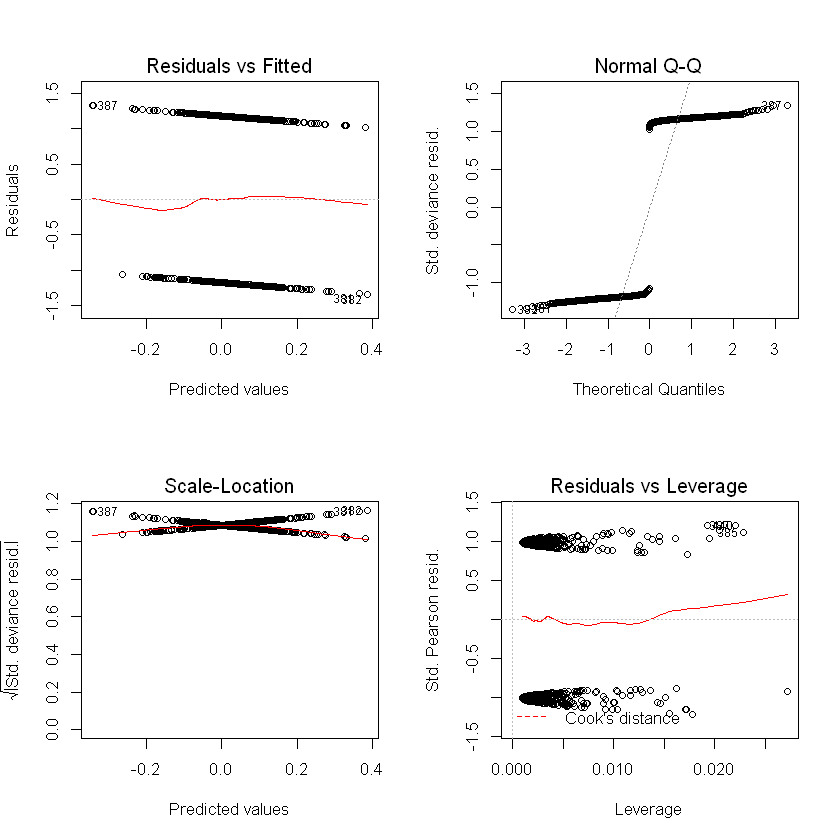

In [10]:
par(mfrow=c(2,2))
plot(glmfit)

# Linear Discriminant Analysis (LDA)
Function `lda` is part of the `MASS` library

Syntax is identical to `lm` and `glm`

LDA uses Bayes Theorem

In [11]:
library(MASS)
ldafit=lda(Direction~Lag1+Lag2,data=Smarket ,subset =train)
ldafit

Call:
lda(Direction ~ Lag1 + Lag2, data = Smarket, subset = train)

Prior probabilities of groups:
    Down       Up 
0.491984 0.508016 

Group means:
            Lag1        Lag2
Down  0.04279022  0.03389409
Up   -0.03954635 -0.03132544

Coefficients of linear discriminants:
            LD1
Lag1 -0.6420190
Lag2 -0.5135293

### Analysis

#### `Prior Probabilities`: $\hat\pi_{down} = 0.492, \hat\pi_{up} = 0.508$
* Which means that in the training set, it goes up 50.8% of the time

#### `Group Means`: Average of each predictor in each class
* Group means for Down/Lag1 and Down/Lag2 are positive, which means that the market usually goes down if it went up (+ve) the previous two days
* Group means for Up are negative, which means that the market usually goes up if it went down (-ve) the previous two days

#### `Coefficients`: Linear combinations of `Lag1` and `Lag2` used for LDA Decision Rule
If $-0.642 \times Lag1 + (-0.514) \times Lag2$ is large, then it predicts that the market will go ***Up***. Otherwise it predicts that the market will go ***Down***.

Let's plot the LDA fit

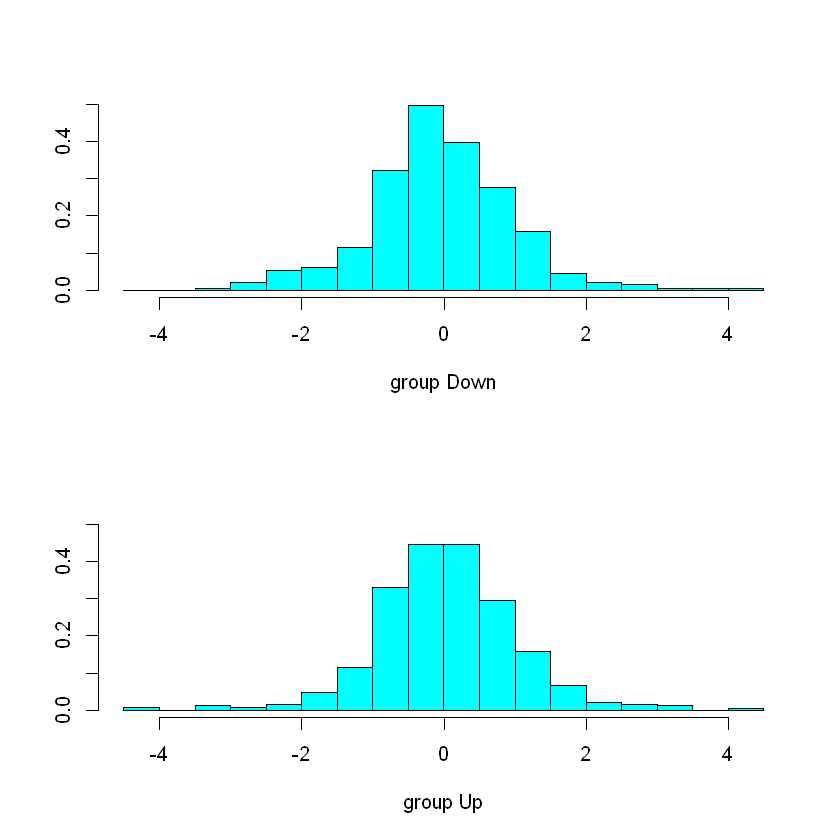

In [12]:
plot(ldafit)

The `predict` fn gives a list with 3 elements. `Class` gives the LDA predictions. `Posterior` is a matrix, the *k*th column contains the *posterior* probability that the obs belongs to the *k*th class. And `x` contains the linear discriminants

In [13]:
ldapred=predict(ldafit,Smarket.2005)
names(ldapred)

ldaclass=ldapred$class   #Predictions
table(ldaclass,Direction.2005)

cat('Error Rate:',round(mean(ldaclass!=Direction.2005)*100),'%\n')


sum(ldapred$posterior[,"Down"]>=0.5)                      #The posterior probs of going Down, threshold = 0.5
length(ldapred$class[ldapred$class=="Down"])

sum(ldapred$posterior[,"Down"]>=0.9)                      #The posterior probs of going Down, threshold = 0.9

[1] "class"     "posterior" "x"

        Direction.2005
ldaclass Down  Up
    Down   35  35
    Up     76 106

Error Rate: 44 %


[1] 70

[1] 70

[1] 0

# Quadratic Discriminant Analysis (QDA)
Use `qda` function, syntax identical to LDA

In [14]:
qdafit=qda(Direction~Lag1+Lag2,data=Smarket,subset=train)
qdafit

Call:
qda(Direction ~ Lag1 + Lag2, data = Smarket, subset = train)

Prior probabilities of groups:
    Down       Up 
0.491984 0.508016 

Group means:
            Lag1        Lag2
Down  0.04279022  0.03389409
Up   -0.03954635 -0.03132544

### Analysis
* Similar to LDA fit, but there are no coefficients, as QDA doesn't have linear coefs

In [15]:
qdaclass=predict(qdafit,Smarket.2005)$class

table(qdaclass,Direction.2005)
cat('Error rate: ',round(100*mean(qdaclass!=Direction.2005)),'%\n')

        Direction.2005
qdaclass Down  Up
    Down   30  20
    Up     81 121

Error rate:  40 %


### Analysis
Error rate is only 40%. Impressive as this is stock market data, which is very hard to predict. 

Possibly, QDA models the true nature of the fit better than LDA/LogReg

# KNN
The `knn` fn is part of the `class` library

Works differently. Instead of first fitting the model and then use it to make predictions, we can form predictions using a single command

Four inputs needed:
1. A matrix with predictors for the *training* data
2. A matrix with predictors for the *test* data
3. A vector with class labels for the *training* observations
4. A value for *K*, i.e. the number of nearest neighbors to be considered

In [16]:
library(class)
train.X=cbind(Lag1,Lag2)[train,]
test.X=cbind(Lag1,Lag2)[!train,]
train.Direction=Direction[train]

We need to set a defined random seed. Because if KNN finds multiple observations tied as nearest neighbors, it will select one at random. So to ensure reproducibility of results, some constant seed should be set.

Let's begin by setting *K*=1

In [17]:
set.seed(1)
knnpred=knn(train.X,test.X,train.Direction,k=1)

table(knnpred,Direction.2005)

(83+43)*100/252   # TruePositive+TrueNegative/Total% in Test set

       Direction.2005
knnpred Down Up
   Down   43 58
   Up     68 83

[1] 50

### Analysis
* Not too good, equivalent to a coin toss
* Because K=1 results in high variance and flexibility
* Let's try with K=3

In [18]:
knnpred=knn(train.X,test.X,train.Direction,k=3)

table(knnpred,Direction.2005)

(87+48)*100/252   # TruePositive+TrueNegative/Total% in Test set

       Direction.2005
knnpred Down Up
   Down   48 54
   Up     63 87

[1] 53.57143

Somewhat better

# Compare All 4 methods

KPI for comparing is Accuracy, defined as 
$$Accuracy = \frac {\sum True Positive + \sum True Positive}{\sum Test Population}$$

Based on these, QDA appears to provide the best fit 

In [19]:
accuracy=cbind(name="Logistic Regression",acc=round(mean(glmpred==Direction.2005)*100))
accuracy=rbind(accuracy,list(name="LDA",acc=round(mean(ldapred$class==Direction.2005)*100)))
accuracy=rbind(accuracy,list(name="QDA",acc=round(mean(qdaclass==Direction.2005)*100)))
accuracy=rbind(accuracy,list(name="KNN",acc=round(mean(knnpred==Direction.2005)*100)))

accuracy

name,acc
Logistic Regression,56
LDA,56
QDA,60
KNN,54


# KNN on Caravan Dataset

Dataset has 85 predictors to measure demographics for 5822 people. Response variable is Purchase, indicates whether the person bought a Caravan insurance. In the dataset, only 6% people actually bought it.t

In [ ]:
dim(Caravan)
attach(Caravan)

In [22]:
summary(Purchase)

No  Yes 
5474  348

KNN predicts the class using the Euclidean distance. So scale matters. For example, if there are predictor variables like salary and age, then a difference of $1000 in salary far outweights a difference of 70y in age.

So if you do a KNN considering salary and age, then salary will dominate the prediction results, age will be pretty much ignored in comparison.

Yet in real life, a difference of 70y is a much bigger difference in relative terms than a $1000 diff in salary

So we should standardize the variables. The `scale` function does that. It manipulates all variables so they have a Mean of 0 and an SD of 1. We'll do it for all columns except the 86th (which is the Purchase variable)

In [25]:
standardized.X = scale(Caravan[,-86])
var(Caravan[,1])
var(Caravan[,2])
var(standardized.X[,1])

[1] 165.0378

[1] 0.1647078

[1] 1

In [ ]:
test=1:1000
train.X=standardized.X[-test,]
test.X=standardized.X[test,]
train.Y=Purchase[-test]
test.Y=Purchase[test]

set.seed(1)

Let's create a helper function that will help in running KNN for multiple K values

In [72]:
doknn=function(k){
    knnpred=knn(train.X,test.X,train.Y,k=k)
    cat("K=",k,"\n")
    cat("Error Rate of prediction:\t\t",mean(test.Y!=knnpred),"\n\n")   # Error rate of prediction
    print(table(test.Y,knnpred))
    cat("\nPPV (KNN,k=",k,"):\t\t",sum(test.Y=="Yes" & knnpred =="Yes")*100/sum(knnpred=="Yes"),"%\n")
    cat("PPV (always predict 'Yes'):\t",sum(test.Y=="Yes")*100/length(test.Y),"%")    
}

In [73]:
doknn(1)

K= 1 
Error Rate of prediction:		 0.118 

      knnpred
test.Y  No Yes
   No  873  68
   Yes  50   9

PPV (KNN,k= 1 ):		 11.68831 %
PPV (always predict 'Yes'):	 5.9 %

So blindly predicting "No" gives an error rate of 6%, but KNN gives an error of 12%!

But let's say that there's a cost for pitching insurance to a customer. So, our objective is to control the cost - which means we must get it right when we say somebody will buy insurance. In other words, Positive Predictive Value (True Positive/Total Predicted Positive) should be maximized. Let's analyze that



So 12% of the people predicted by KNN will actually end up buying insurance. As opposed to 6% if we blindly predicted "Yes". That's some improvement

Now let's try with K=3

In [74]:
doknn(3)

K= 3 
Error Rate of prediction:		 0.073 

      knnpred
test.Y  No Yes
   No  922  19
   Yes  54   5

PPV (KNN,k= 3 ):		 20.83333 %
PPV (always predict 'Yes'):	 5.9 %

Even better! Let's try with K=5

In [75]:
doknn(5)

K= 5 
Error Rate of prediction:		 0.066 

      knnpred
test.Y  No Yes
   No  930  11
   Yes  55   4

PPV (KNN,k= 5 ):		 26.66667 %
PPV (always predict 'Yes'):	 5.9 %

Let's also try Logistic Regression, with cutoffs at 0.5 and 0.25. TO begin with, let's create a helper function

In [94]:
do_glm = function(cutoff){
    glm.fit=glm(Purchase~.,data=Caravan,family=binomial,subset=-test)
    
    glm.probs=predict(glm.fit,Caravan[test,],type="response")
    
    glm.pred=rep("No",1000)
    
    glm.pred[glm.probs>cutoff]="Yes"
    
    cat("Cutoff=",cutoff)
    cat("\n")
    print(table(glm.pred,test.Y))
    cat("\n")
    
    cat("\nPPV (Cutoff=",cutoff,"):\t\t",
        sum(test.Y=="Yes" & glm.pred =="Yes")*100/sum(glm.pred=="Yes"),"%\n")
}

In [95]:
do_glm(0.5)
do_glm(0.25)

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

Cutoff= 0.5
        test.Y
glm.pred  No Yes
     No  934  59
     Yes   7   0


PPV (Cutoff= 0.5 ):		 0 %


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

Cutoff= 0.25
        test.Y
glm.pred  No Yes
     No  919  48
     Yes  22  11


PPV (Cutoff= 0.25 ):		 33.33333 %
